In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import HTML, display

from nlp_adversarial_attacks.utils.file_io import load_json
from nlp_adversarial_attacks.utils.notebook import (
    columns_order_to_sort,
    display_tables,
    extract_infos,
    plot_confusion_matrix_serie,
    remove_columns,
    scatter_plot,
    select_experiment,
)

In [2]:
all_experiments_dir = Path("data_tcab/detection-experiments/")

df_list = []
for metrics_path in all_experiments_dir.glob("**/metrics.json"):
    print(metrics_path)
    infos = extract_infos(metrics_path)
    metrics = load_json(metrics_path)
    infos.update(metrics)
    df_list.append(infos)

df = pd.DataFrame(df_list)

data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LGB\all\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LGB\bert\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LGB\bert+tp\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LGB\bert+tp+lm\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LR\all\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LR\bert\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LR\bert+tp\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LR\bert+tp+lm\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\RF\all\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\RF\bert\metr

In [3]:
for column in df.columns:
    if "confusion_matrix" in column:
        df[column] = df[column].apply(lambda x: np.array(x))

df = remove_columns(df, ["train", "test"])

In [4]:
df.sample(3)

,target_dataset,target_model,embeddings,setting,classification_model,feature_setting,is_binary,validation_accuracy,validation_balanced_accuracy,validation_confusion_matrix,validation_recall,validation_precision,validation_f1_score,validation_roc_auc,best_params,classes_labels,important_features,feature_names,coef,intercept
3,allocine,distilcamembert,default,clean_vs_all,LGB,bert+tp+lm,True,0.787964,0.787964,"[[1533, 245], [509, 1269]]",0.713723,0.838177,0.770960,0.787964,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...","[clean, perturbed]",None,"[lm_perplexity_region0, lm_perplexity_region1,...",None,None
27,allocine,distilcamembert,fr+small,clean_vs_all,LGB,bert+tp+lm,True,0.858549,0.858549,"[[1625, 153], [350, 1428]]",0.803150,0.903226,0.850253,0.858549,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...","[clean, perturbed]",None,"[lm_perplexity_region0, lm_perplexity_region1,...",None,None
6,allocine,distilcamembert,default,clean_vs_all,LR,bert+tp,True,0.727503,0.727503,"[[1421, 357], [612, 1166]]",0.655793,0.765594,0.706453,0.727503,{'logisticregression__C': 0.1},"[clean, perturbed]",None,"[avg_word_length_mean_region0, avg_word_length...",{'perturbed': {'avg_word_length_mean_region0':...,None


In [5]:
df.columns

Index(['target_dataset', 'target_model', 'embeddings', 'setting',
       'classification_model', 'feature_setting', 'is_binary',
       'validation_accuracy', 'validation_balanced_accuracy',
       'validation_confusion_matrix', 'validation_recall',
       'validation_precision', 'validation_f1_score', 'validation_roc_auc',
       'best_params', 'classes_labels', 'important_features', 'feature_names',
       'coef', 'intercept'],
      dtype='object')

In [6]:
COLUMNS_ORDER = {
    "embeddings": ["default", "fr+small"],
    "setting": ["clean_vs_all", "multiclass_with_clean"],
    "feature_setting": ["bert", "bert+tp", "bert+tp+lm", "all"],
    "classification_model": ["LR", "RF", "LGB"],
}
COLUMNS_KEY = columns_order_to_sort(COLUMNS_ORDER)

## Table

In [7]:
display_tables(
    df, COLUMNS_ORDER, COLUMNS_KEY, transpose=False, sort_metric="validation_accuracy"
)

,validation_accuracy,validation_balanced_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc
embeddings,,,,,,
fr+small,0.731748,0.715508,0.813320,0.867397,0.838480,0.845215
default,0.659793,0.650328,0.713301,0.805408,0.754821,0.774817


,validation_accuracy,validation_balanced_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc
setting,,,,,,
clean_vs_all,0.810016,0.810016,0.763311,0.836402,0.796650,0.810016
multiclass_with_clean,0.581525,0.555820,nan,nan,nan,nan


,validation_accuracy,validation_balanced_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc
feature_setting,,,,,,
all,0.818797,0.803379,0.953693,0.939337,0.946193,0.945726
bert+tp+lm,0.703930,0.688953,0.748313,0.850563,0.795894,0.808727
bert+tp,0.658748,0.648435,0.685696,0.793913,0.734867,0.755062
bert,0.601608,0.590905,0.665542,0.761796,0.709646,0.730549


,validation_accuracy,validation_balanced_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc
classification_model,,,,,,
LR,0.741030,0.729108,0.790284,0.854576,0.820621,0.829935
LGB,0.708415,0.693802,0.760124,0.853654,0.802227,0.818441
RF,0.637867,0.625844,0.739525,0.800977,0.767103,0.781672


In [8]:
display_tables(df, COLUMNS_ORDER, COLUMNS_KEY, transpose=True)

embeddings,default,fr+small
feature,,
validation_accuracy,0.659793,0.731748
validation_balanced_accuracy,0.650328,0.715508
validation_recall,0.713301,0.813320
validation_precision,0.805408,0.867397
validation_f1_score,0.754821,0.838480
validation_roc_auc,0.774817,0.845215


setting,clean_vs_all,multiclass_with_clean
feature,,
validation_accuracy,0.810016,0.581525
validation_balanced_accuracy,0.810016,0.555820
validation_recall,0.763311,nan
validation_precision,0.836402,nan
validation_f1_score,0.796650,nan
validation_roc_auc,0.810016,nan


feature_setting,bert,bert+tp,bert+tp+lm,all
feature,,,,
validation_accuracy,0.601608,0.658748,0.703930,0.818797
validation_balanced_accuracy,0.590905,0.648435,0.688953,0.803379
validation_recall,0.665542,0.685696,0.748313,0.953693
validation_precision,0.761796,0.793913,0.850563,0.939337
validation_f1_score,0.709646,0.734867,0.795894,0.946193
validation_roc_auc,0.730549,0.755062,0.808727,0.945726


classification_model,LR,RF,LGB
feature,,,
validation_accuracy,0.741030,0.637867,0.708415
validation_balanced_accuracy,0.729108,0.625844,0.693802
validation_recall,0.790284,0.739525,0.760124
validation_precision,0.854576,0.800977,0.853654
validation_f1_score,0.820621,0.767103,0.802227
validation_roc_auc,0.829935,0.781672,0.818441


## Scatter plot

In [9]:
def scatter_plot_loop(df, loop_column, ax_column, x_column, color_column, metric):
    for name, df_group in df.groupby(loop_column):
        display(HTML(f"<h3>{loop_column} = {name}<h3/>"))
        scatter_plot(df_group, COLUMNS_ORDER, ax_column, x_column, color_column, metric)

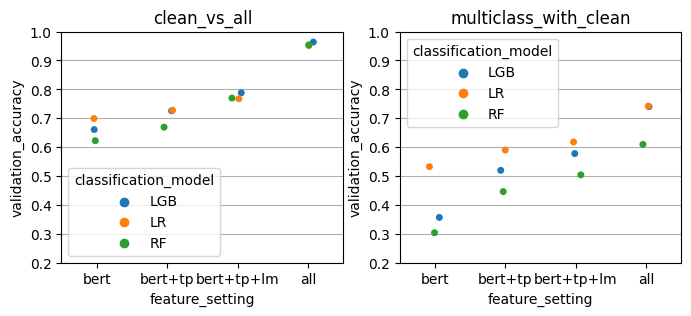

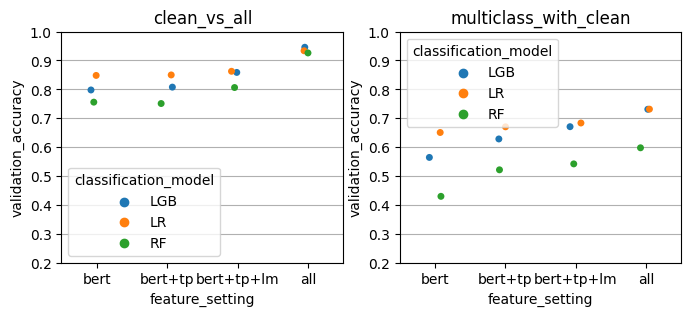

In [10]:
scatter_plot_loop(
    df,
    loop_column="embeddings",
    ax_column="setting",
    x_column="feature_setting",
    color_column="classification_model",
    metric="validation_accuracy",
)

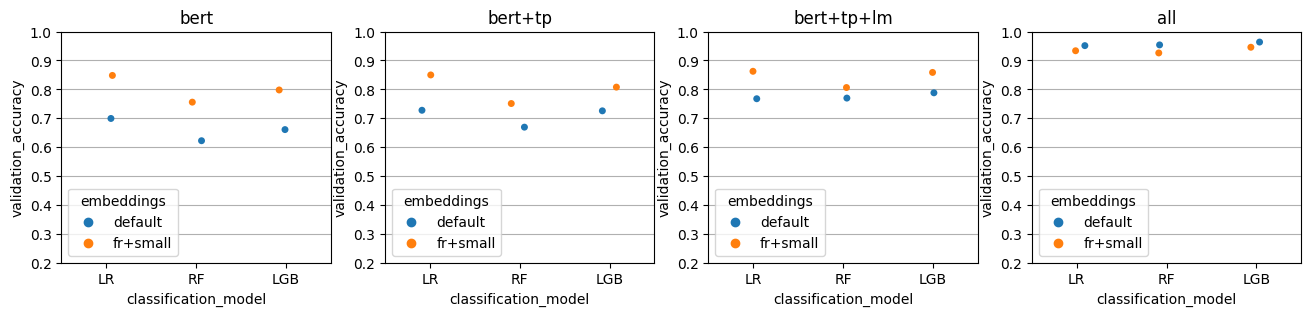

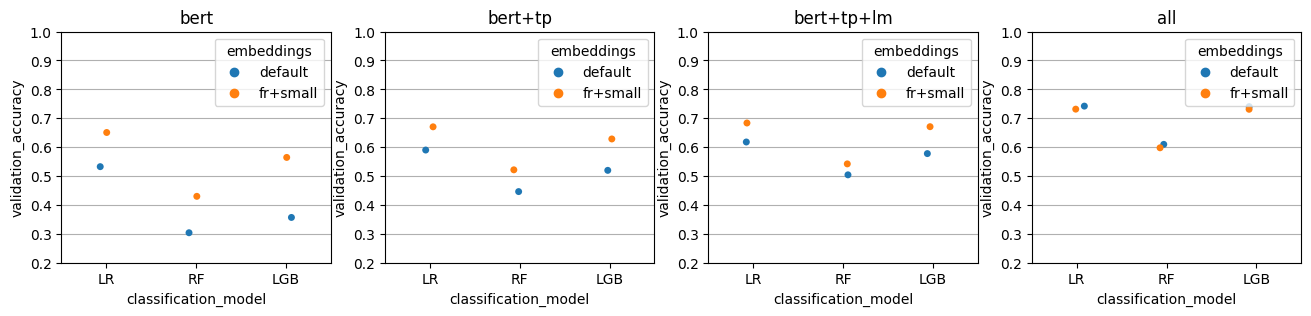

In [11]:
scatter_plot_loop(
    df,
    loop_column="setting",
    ax_column="feature_setting",
    x_column="classification_model",
    color_column="embeddings",
    metric="validation_accuracy",
)

## Confusion matrix

In [12]:
df["classes_labels"] = df["classes_labels"].apply(lambda x: tuple(x))
assert (df.groupby("is_binary")["classes_labels"].nunique() == 1).all()

In [13]:
BINARY_CLASSES = df[df["is_binary"]].iloc[0]["classes_labels"]
MULTI_CLASSES = df[~df["is_binary"]].iloc[0]["classes_labels"]

In [14]:
groupby_column = "feature_setting"
cm_serie = (
    df[df.setting == "clean_vs_all"]
    .groupby(groupby_column)["validation_confusion_matrix"]
    .mean()
    .sort_index(key=COLUMNS_KEY[groupby_column])
)
cm_serie

feature_setting
bert          [[1414.5, 363.5], [594.6666666666666, 1183.333...
bert+tp       [[1465.8333333333333, 312.1666666666667], [558...
bert+tp+lm    [[1545.3333333333333, 232.66666666666666], [44...
all           [[1667.3333333333333, 110.66666666666667], [82...
Name: validation_confusion_matrix, dtype: object

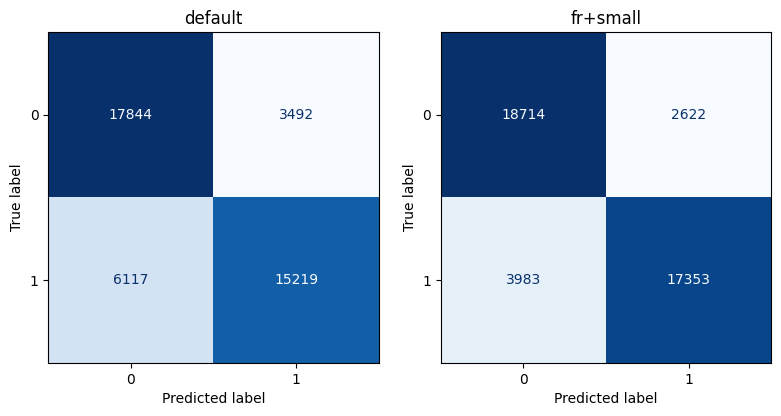

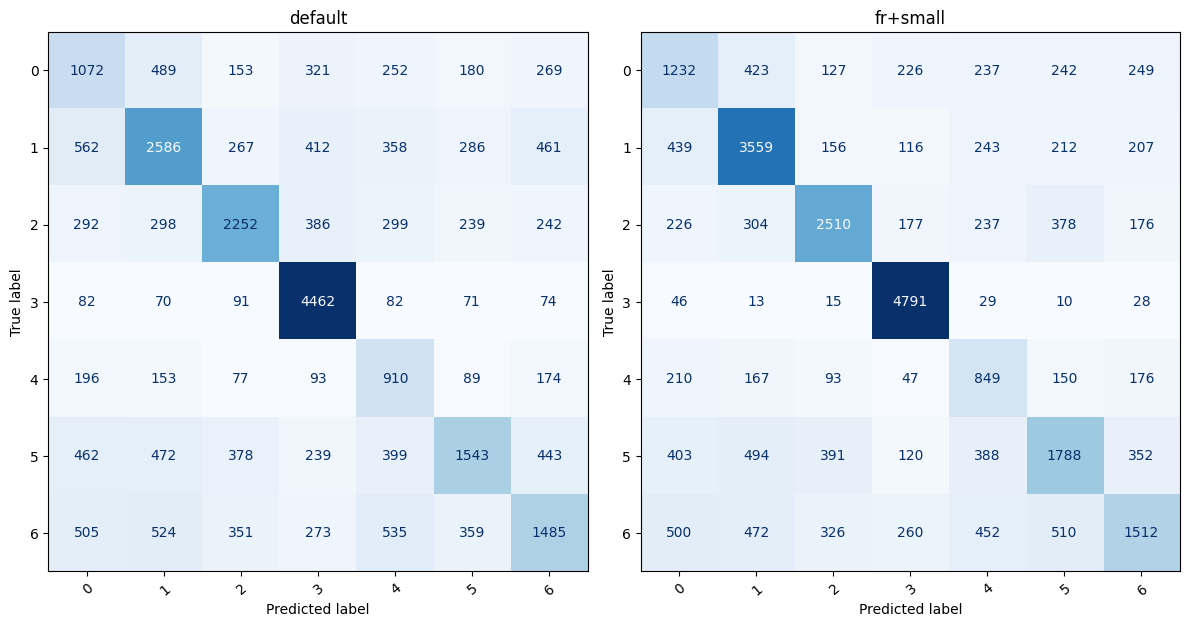

In [15]:
column1 = "setting"
column_groupby = "embeddings"

for modality1 in COLUMNS_ORDER[column1]:
    cm_serie = (
        select_experiment(df, COLUMNS_ORDER, **{column1: modality1}, verbose=True)
        .groupby(column_groupby)["validation_confusion_matrix"]
        .sum()
    )
    plot_confusion_matrix_serie(cm_serie)

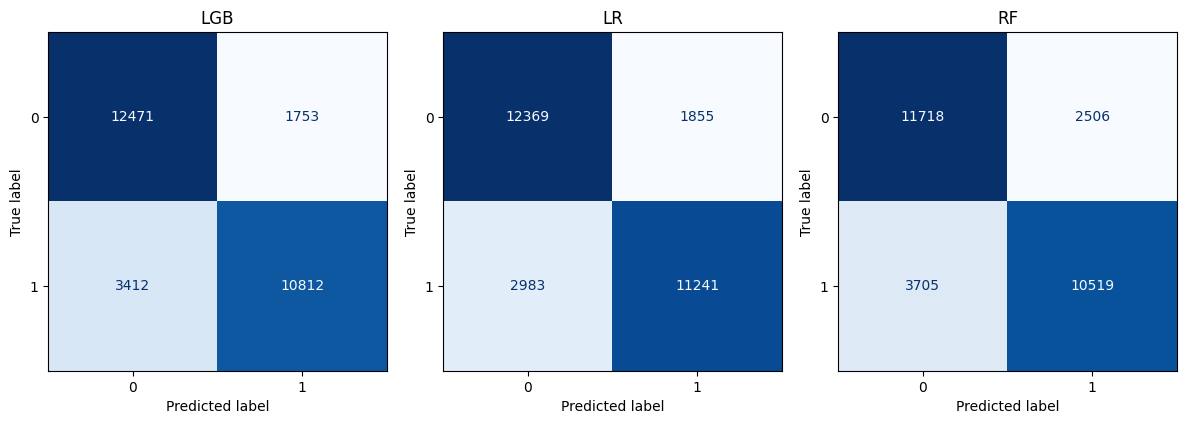

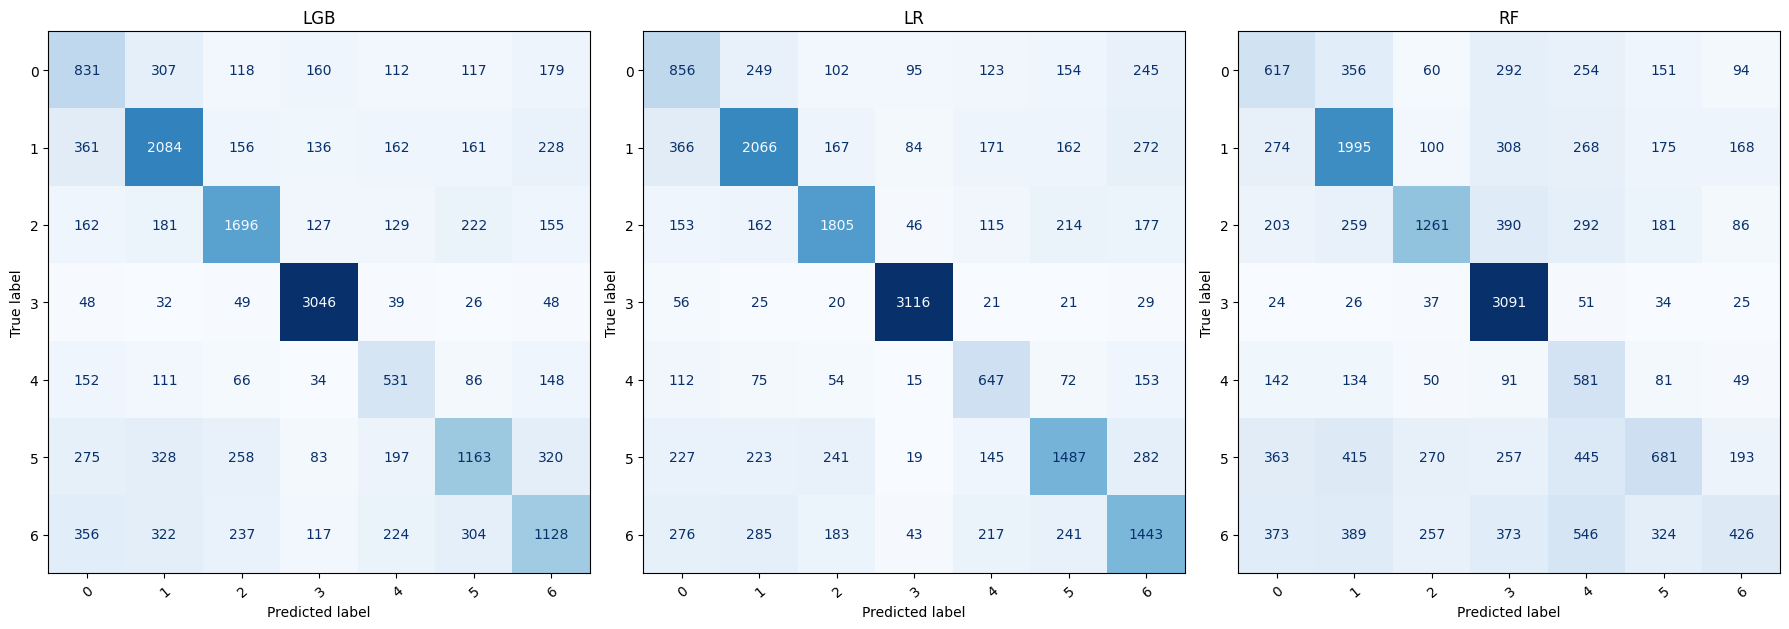

In [16]:
column1 = "setting"
column_groupby = "classification_model"

for modality1 in COLUMNS_ORDER[column1]:
    cm_serie = (
        select_experiment(df, COLUMNS_ORDER, **{column1: modality1}, verbose=True)
        .groupby(column_groupby)["validation_confusion_matrix"]
        .sum()
    )
    plot_confusion_matrix_serie(cm_serie)

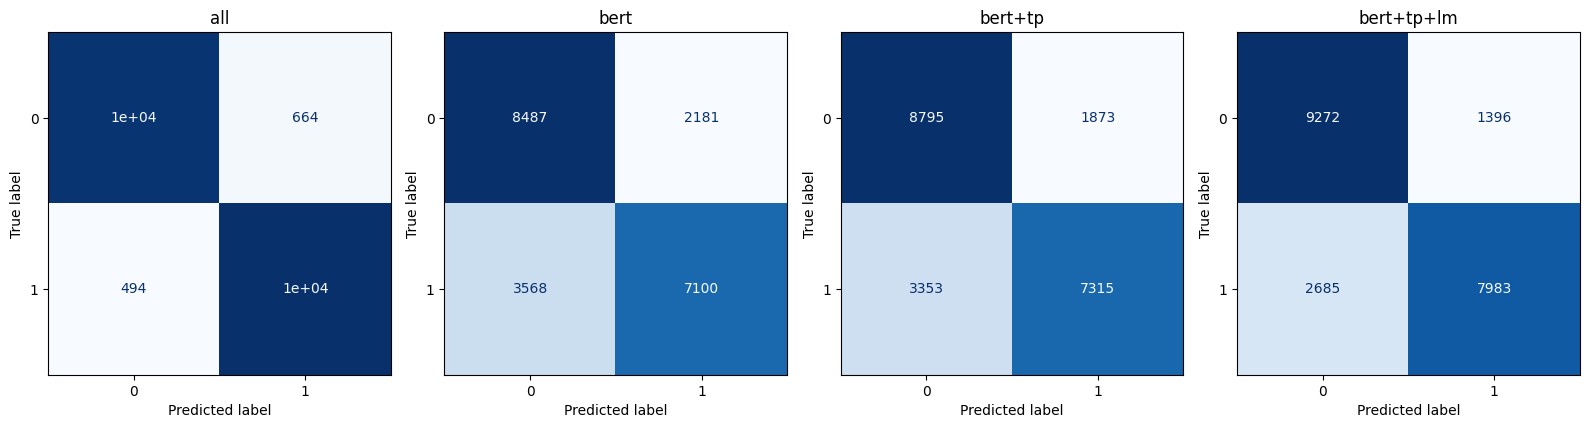

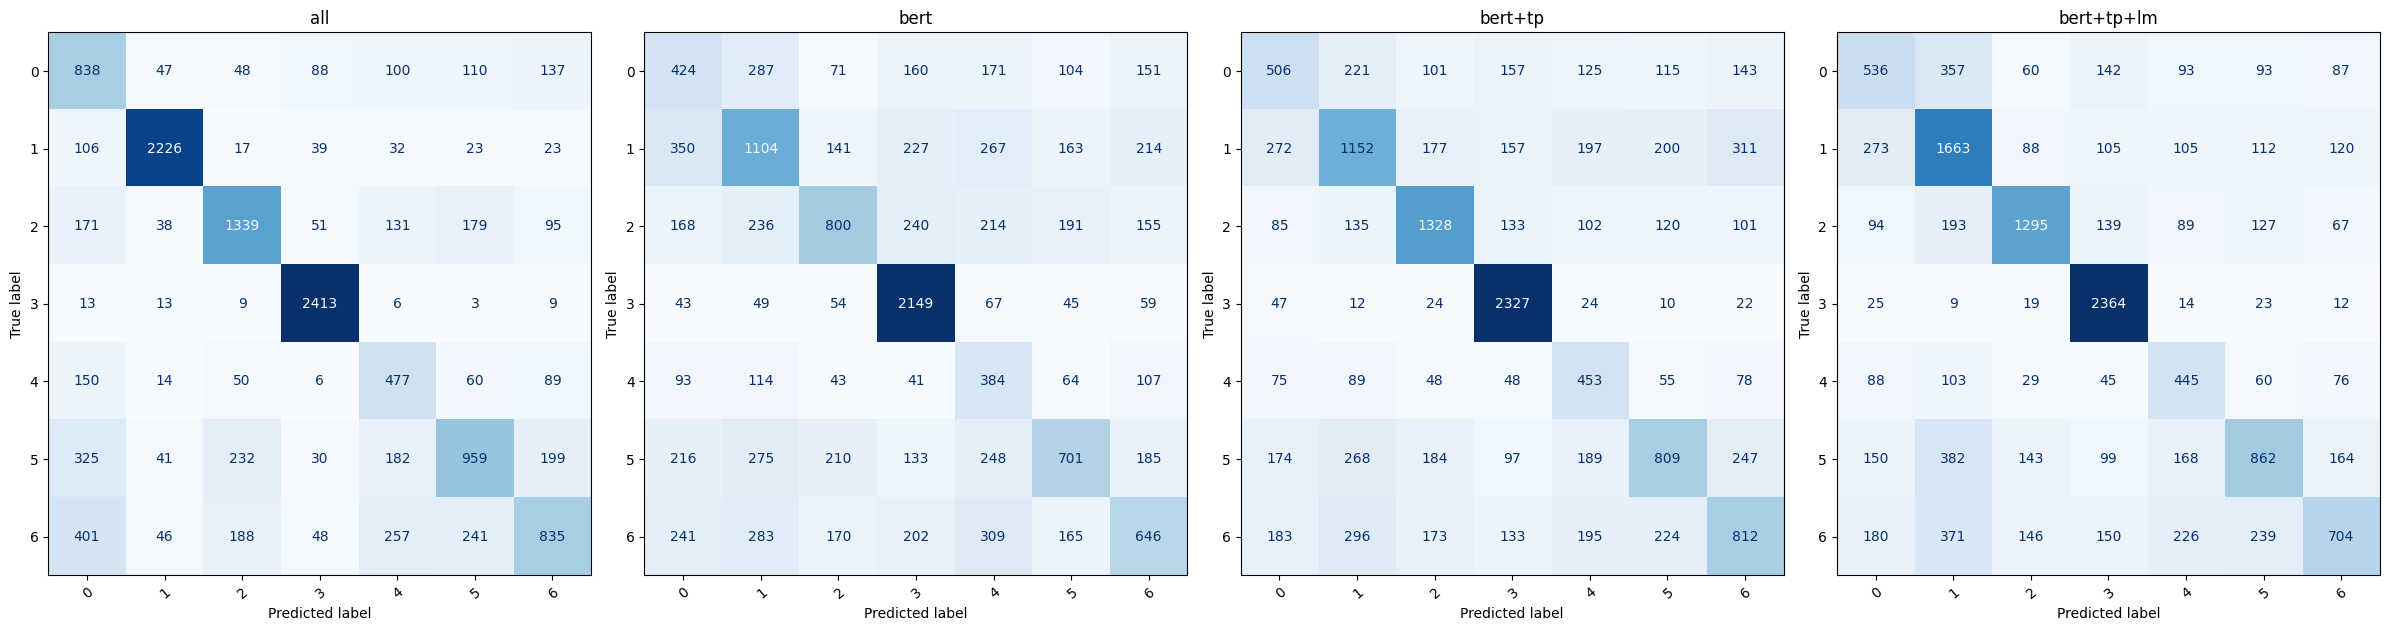

In [17]:
column1 = "setting"
column_groupby = "feature_setting"

for modality1 in COLUMNS_ORDER[column1]:
    cm_serie = (
        select_experiment(df, COLUMNS_ORDER, **{column1: modality1}, verbose=True)
        .groupby(column_groupby)["validation_confusion_matrix"]
        .sum()
    )
    plot_confusion_matrix_serie(cm_serie)

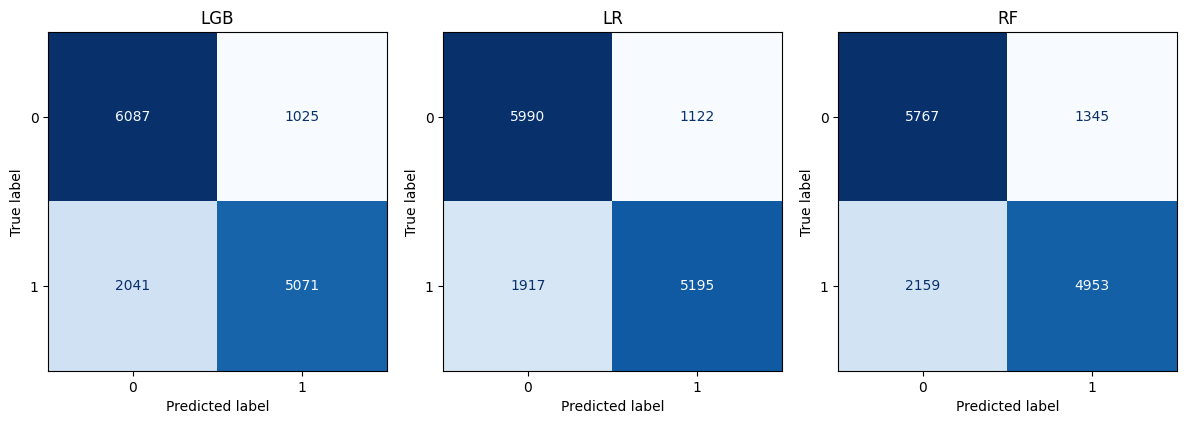

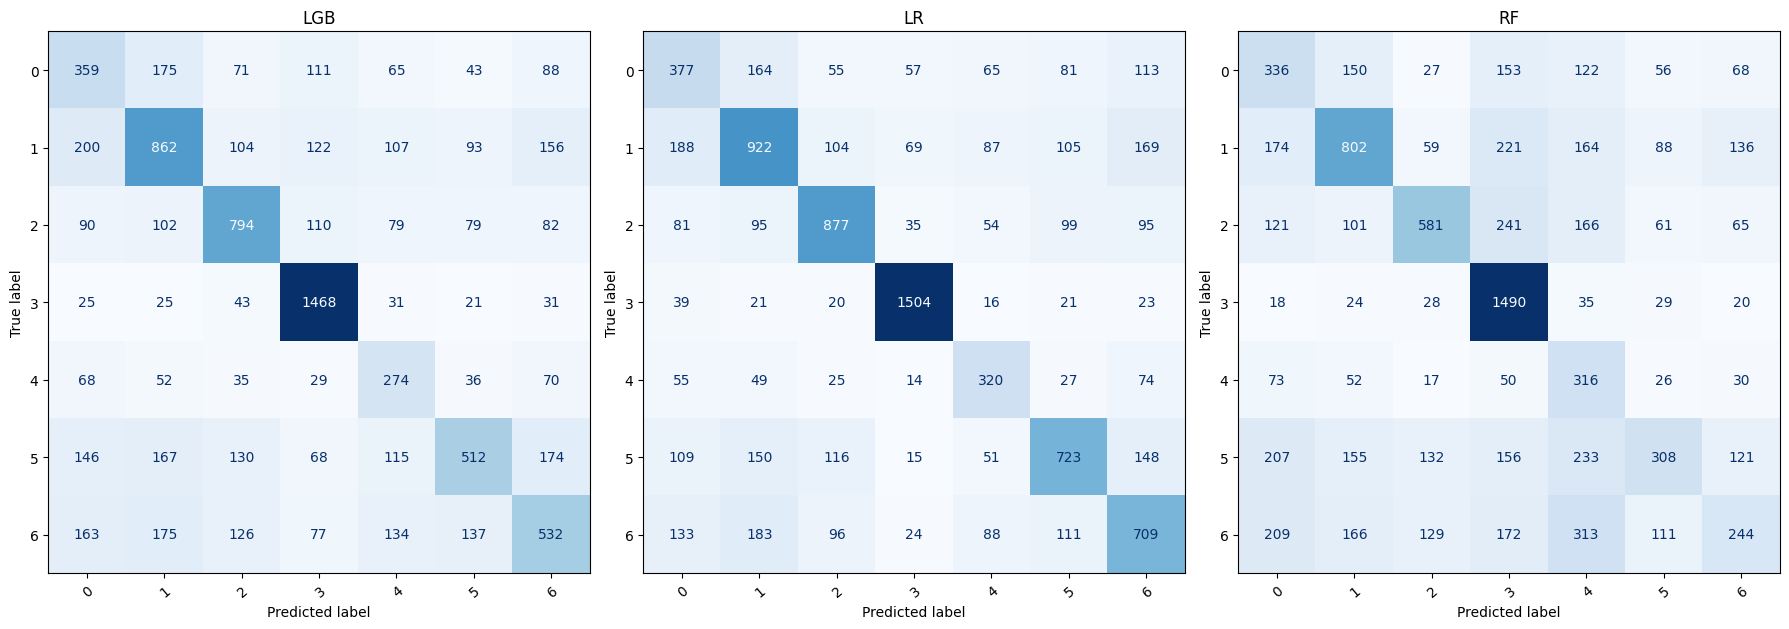

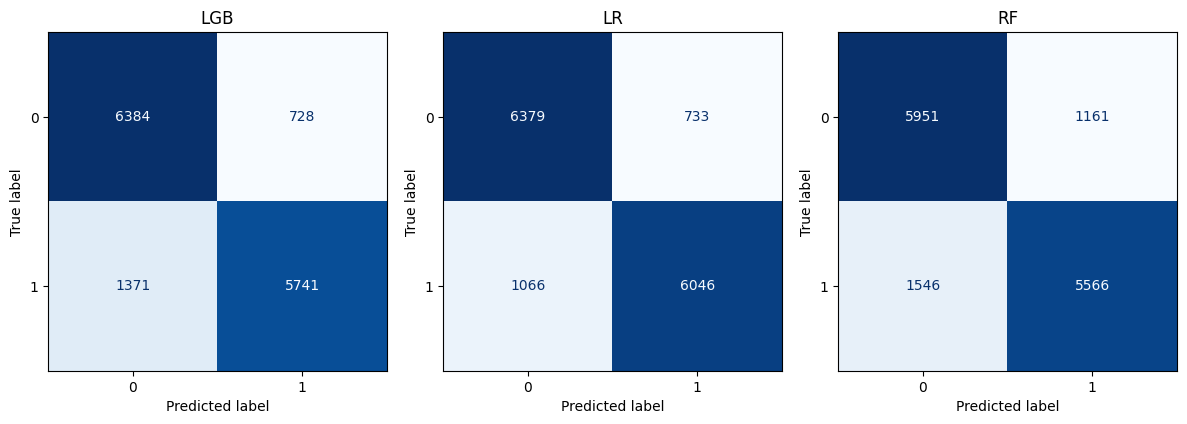

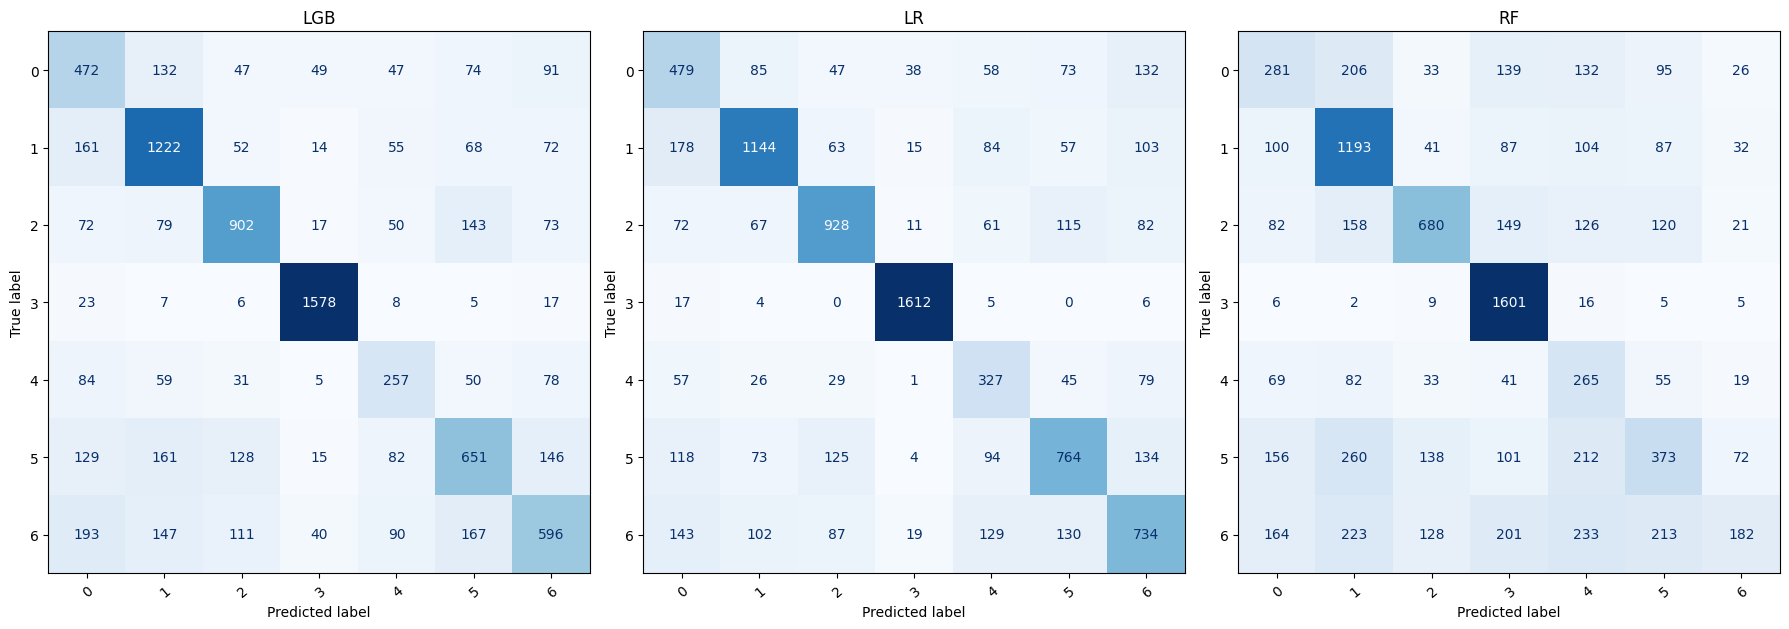

In [18]:
column1 = "embeddings"
column2 = "setting"
column_groupby = "classification_model"

for modality1 in COLUMNS_ORDER[column1]:
    for modality2 in COLUMNS_ORDER[column2]:
        cm_serie = (
            select_experiment(
                df,
                COLUMNS_ORDER,
                **{column1: modality1, column2: modality2},
                verbose=True
            )
            .groupby(column_groupby)["validation_confusion_matrix"]
            .sum()
        )
        plot_confusion_matrix_serie(cm_serie)